In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
model = models.resnet18()

In [4]:
BATCH_SIZE = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes

('airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [8]:
# Define the ResidualBlock as provided
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

# Define the SeptLinear layer
class SeptLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(SeptLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.01)
        self.bias = nn.Parameter(torch.randn(out_features) * 0.01)

    def forward(self, x):
        # Compute the scale factor
        scale = 1.0 / self.weight.abs().mean().clamp(min=1e-5)  # Avoid division by very small values

        # Scale the weights
        scaled_weight = self.weight * scale

        # Define the possible septenary levels
        levels = torch.tensor([-2, -1, -0.5, 0, 0.5, 1, 2], device=scaled_weight.device)

        # Quantize weights to the nearest septenary level
        expanded_weights = scaled_weight.unsqueeze(-1)  # Expand last dimension to compare with levels
        differences = (expanded_weights - levels).abs()  # Compute absolute difference from each level
        quantized_weight = levels[differences.argmin(dim=-1)]  # Choose the level with the smallest difference

        # Dequantize the weights
        quantized_weight = quantized_weight / scale  # Scale back to original magnitude

        # Apply linear transformation
        return F.linear(x, quantized_weight, self.bias)

# Update ResNet to use SeptLinear instead of BitLinear
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        
        self.dropout = nn.Dropout(p=0.5)
        
        # Replace BitLinear with SeptLinear
        self.fc = SeptLinear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        
        out = self.dropout(out)
        
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock)

# Instantiate the model
net = ResNet18().to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)

In [10]:
all_iteration_losses = []
validation_accuracies = []
for epoch in range(20):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        all_iteration_losses.append(loss.item())

        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 50 == 0:
            print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% '
                  % (epoch + 1, (i + 1), sum_loss / (i + 1), 100. * correct / total))

    print('Testing...')
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100 * correct / total  
        print('Test Accuracy: %.3f%%' % test_acc) 
        validation_accuracies.append(test_acc)  

print('Training complete.')


Epoch: 1
[epoch:1, iter:50] Loss: 1.963 | Acc: 25.625% 
[epoch:1, iter:100] Loss: 1.832 | Acc: 31.062% 
[epoch:1, iter:150] Loss: 1.758 | Acc: 34.333% 
[epoch:1, iter:200] Loss: 1.691 | Acc: 37.164% 
[epoch:1, iter:250] Loss: 1.631 | Acc: 39.522% 
[epoch:1, iter:300] Loss: 1.580 | Acc: 41.578% 
[epoch:1, iter:350] Loss: 1.526 | Acc: 43.703% 
Testing...
Test Accuracy: 56.370%

Epoch: 2
[epoch:2, iter:50] Loss: 1.105 | Acc: 60.500% 
[epoch:2, iter:100] Loss: 1.080 | Acc: 61.727% 
[epoch:2, iter:150] Loss: 1.063 | Acc: 62.536% 
[epoch:2, iter:200] Loss: 1.038 | Acc: 63.383% 
[epoch:2, iter:250] Loss: 1.019 | Acc: 64.119% 
[epoch:2, iter:300] Loss: 1.001 | Acc: 64.753% 
[epoch:2, iter:350] Loss: 0.985 | Acc: 65.315% 
Testing...
Test Accuracy: 70.590%

Epoch: 3
[epoch:3, iter:50] Loss: 0.814 | Acc: 72.062% 
[epoch:3, iter:100] Loss: 0.815 | Acc: 72.078% 
[epoch:3, iter:150] Loss: 0.796 | Acc: 72.495% 
[epoch:3, iter:200] Loss: 0.788 | Acc: 72.730% 
[epoch:3, iter:250] Loss: 0.782 | Acc: 72

[56.37, 70.59, 71.7, 69.6, 80.05, 80.53, 81.34, 83.64, 82.69, 85.99, 82.97, 85.17, 88.23, 84.6, 87.32, 88.06, 88.74, 88.93, 88.71, 88.41]


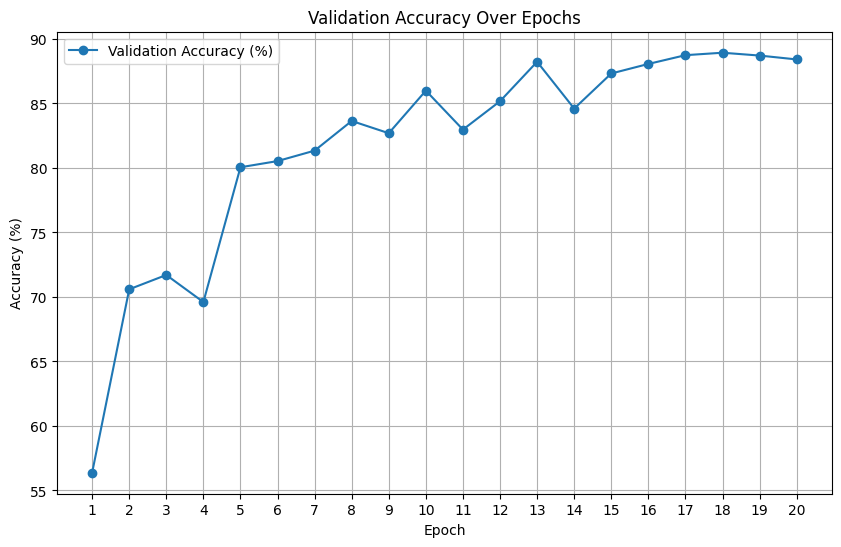

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

print(validation_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy (%)', marker='o')

plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(validation_accuracies) + 1))  
plt.legend()
plt.grid()
plt.show()


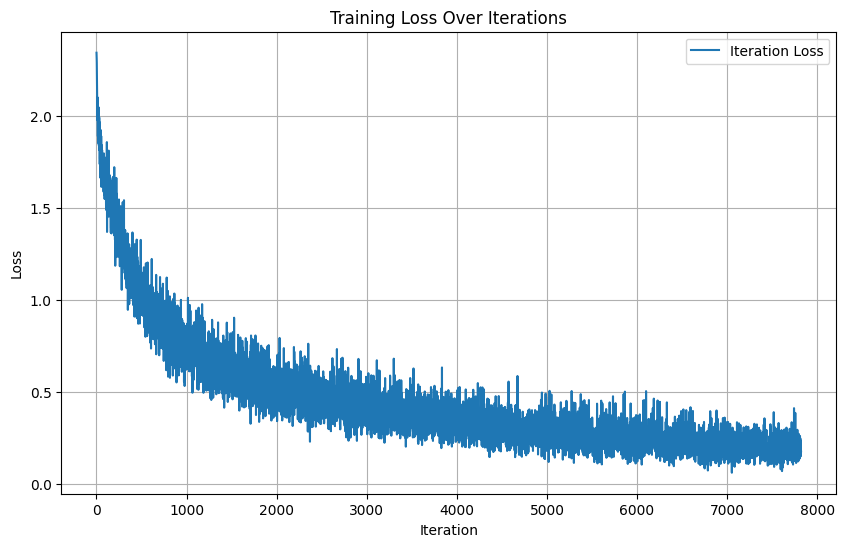

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(all_iteration_losses) + 1), all_iteration_losses, label='Iteration Loss')

plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
